<div style="border-radius: 15px; border:solid navy 2px; padding: 10px"> 
    <h1> Определение возраста покупателей</h1>
    
## Описание исследования

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В проекте используется набор фотографий людей с указанием возраста.
    

### Целевая метрика:

<font color='navy'> MAE < 8 на тестовой выборке</font>
    
### Задачи, которая должна уметь решать модель:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

## Исследовательский анализ данных
### Импорт библиотек

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')

### Анализ данных

In [2]:
labels = pd.read_csv(
    '/datasets/faces/labels.csv'
)
train_datagen = ImageDataGenerator(
    rescale=1./255
)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345
)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
def describe_boxplot_hist(df):

# Показатели описательной статистики
    display(df.describe())

# Диаграмма размаха 
    flierprops = dict(
        marker='o', 
        markerfacecolor='None', 
        markersize=3,  
        markeredgecolor='black'
    )
    sns.set(
        rc={
            'figure.figsize':(16,1.5)
        })
    ax = sns.boxplot(
        x=df,
        showmeans=True,
        color ="darkblue",
        width = .4,
        meanprops={
            "marker":"o",
            "markerfacecolor":"white", 
            "markeredgecolor":"black",
            "markersize":"8"
        },
        flierprops = flierprops
    )
    plt.title(
        'Диаграмма размаха', 
        fontsize=15
    )
# Гистограмма    
    fig= plt.subplots(
        figsize=(16,3)
    )
    sns.distplot(
        df, 
        bins = 100,
        color = 'darkblue'
    ).set_title(
        'Гистограмма', 
        fontsize=15
    )
    plt.xticks(
        np.arange(0, 105, step=5)
    )
    plt.vlines(
        df.mean(),
        0,0.04,
        color = 'navy', 
        label="Среднее"
    )
    plt.vlines(
        df.median(), 
        0,0.04, 
        linestyle = 'dashed', 
        color = 'navy', 
        label="Медиана"
    )
    plt.legend()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

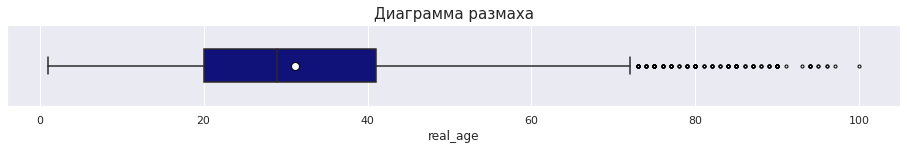

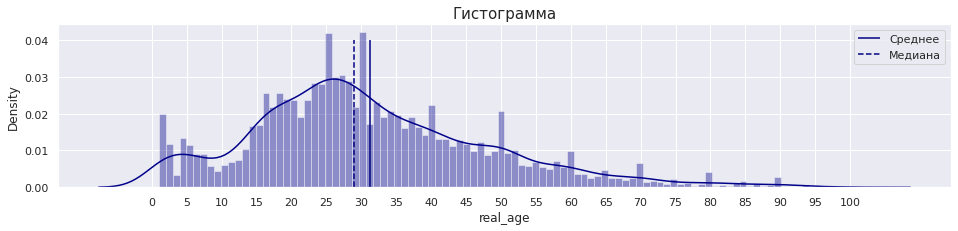

In [6]:
describe_boxplot_hist(
    labels['real_age']
)

In [7]:
labels[
    'real_age'
].value_counts().head()

30    317
25    315
27    229
26    226
28    217
Name: real_age, dtype: int64

На основании гистограммы можно отметить, что в данных выделяется большое количество людей в возрасте 30 и 25 лет, на гистограмме видны эти пики, и данные `value_counts()` это подтверждают. 
    
Довольно много фотографий совсем маленьких детей (до 5 лет). Их больше, чем фотографий детей 12-15 лет. Это может помешать в решении задачи про возраст продажи алкоголя (для данной задачи важнее отличить человека 16 и 18 лет, чем 2 и 5 лет).
    
Также можно в целом отметить, что людей более старшего возраста (больше 50) в общем на фотографиях меньше, чем более молодых. От этого и медиана и среднее смещены от середины всего диапазона представленных возрастов.

Очень заметны пики на юбилейных возрастах - 30, 40, 50, 60, 70, 80, 90. Это может говорить о том, что некоторые возрасты в датасете округлены до ближайшего круглого числа, сделовательно качество данных снижается.

Также можно заметить, что данные распределены неравномерно - одних возрастов больше, других меньше. Этот факт также не способствует улучшению качества. 

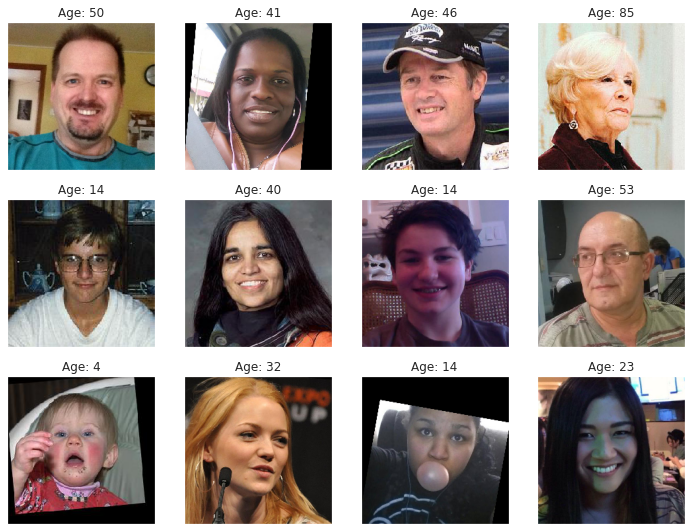

In [8]:
features, target = next(
    train_gen_flow
)

fig = plt.figure(
    figsize=(10,10)
)
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(
        'Age: ' + str(target[i])
    )

In [9]:
labels.sample(
    n=10, 
    random_state=12345
)

,file_name,real_age
5370,005370.jpg,50
4516,004516.jpg,41
3968,003968.jpg,46
2188,002188.jpg,85
5833,005833.jpg,14
5521,005521.jpg,40
5393,005393.jpg,14
3913,003913.jpg,53
934,000934.jpg,4
6260,006264.jpg,32


<div style="border-radius: 15px; border:solid navy 1.5px; padding: 10px"> 
    <h3> Вывод </h3>

* В датасете более 7.5 тысяч изображений. 
    
    
* Датасет содержит набор фотографий людей с отметкой о возрасте, пропусков в датасете нет. В случайной выборке фотографий из датасета изображения цветные, среднего качества, некоторые из них повернуты или смещены. 

    
* Средний возраст людей на фотографиях - 31 год, медианный - 29. Больше всего фотографий людей в возрасте от 20 до 41 года. Возраст самого юного человека на фотографии - всего 1 год, самого пожилого - 100 лет. Распределение количества фотографий по возрасту смещено влево, поскольку медиана меньше среднего значения. 
    
    
* Распределение данных по возрастным категориям достаточно равномерное, что позволит решить поставленные задачи (рекомендация товаров категориям пользователей и определение возраста для продажи алкоголя), однако для более корректного решения задач следует использовать датасет большего размера и с добавлением разметки по полу человека на фотографии.
    
    
* На фотографиях изображены как мужчины, так и женщины. Распределение количества фотографий по гендерному признаку изображенных на них людей проанализировать на данном этапе нельзя, поскольку в датасете существует только отметка о возрасте. 
    
    
* По выведенным примерам фотографий с разметкой можно отметить, что данные корректны, никаких резких аномалий при первичном анализе не видно. Количество данных не слишком большое (7.5 тысяч), особенно учитывая, что мы решаем задачу регрессии. 

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(
        path + 'labels.csv'
    )
    train_datagen = ImageDataGenerator(
        validation_split=0.25, 
        horizontal_flip=True, 
        rescale=1./255
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + 'final_files/', 
        x_col='file_name', 
        y_col='real_age', 
        target_size=(224, 224), 
        batch_size=16, 
        class_mode='raw',
        subset='training', 
        seed=12345
    )
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(
        path + 'labels.csv'
    )
    test_datagen = ImageDataGenerator(
        validation_split=0.25, 
        rescale=1./255
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + 'final_files/',
        x_col='file_name', 
        y_col='real_age',
        target_size=(224, 224), 
        batch_size=16, 
        class_mode='raw',
        subset='validation', 
        seed=12345
    )
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        weights='imagenet', 
        input_shape=input_shape, 
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(
        GlobalAveragePooling2D()
    )
    model.add(
        Dense(
            1, 
            activation='relu'
        ))
    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer, 
        loss='mse', 
        metrics=['mae']
    )

    return model


def train_model(
    model, 
    train_data, 
    test_data, 
    batch_size=None, 
    epochs=10,
    steps_per_epoch=None, 
    validation_steps=None
):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data, 
        validation_data=test_data, 
        batch_size=batch_size, 
        epochs=epochs,
        steps_per_epoch=steps_per_epoch, 
        validation_steps=validation_steps, 
        verbose=2
    )

    return model

```

**Результат обучения модели:**

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-09-08 21:41:41.557125: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-08 21:41:41.858090: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 49s - loss: 233.9711 - mae: 11.0397 - val_loss: 283.9186 - val_mae: 13.2917
Epoch 2/10
356/356 - 39s - loss: 88.0106 - mae: 7.1412 - val_loss: 177.0000 - val_mae: 9.8124
Epoch 3/10
356/356 - 39s - loss: 56.9339 - mae: 5.7352 - val_loss: 79.2236 - val_mae: 6.6213
Epoch 4/10
356/356 - 38s - loss: 42.8432 - mae: 4.9885 - val_loss: 103.2386 - val_mae: 7.3336
Epoch 5/10
356/356 - 38s - loss: 33.9509 - mae: 4.4337 - val_loss: 72.5620 - val_mae: 6.3628
Epoch 6/10
356/356 - 38s - loss: 24.4259 - mae: 3.7942 - val_loss: 66.3548 - val_mae: 6.0699
Epoch 7/10
356/356 - 38s - loss: 20.5046 - mae: 3.4702 - val_loss: 69.8626 - val_mae: 6.2332
Epoch 8/10
356/356 - 41s - loss: 16.4837 - mae: 3.0968 - val_loss: 69.3544 - val_mae: 6.2163
Epoch 9/10
356/356 - 39s - loss: 13.7316 - mae: 2.8370 - val_loss: 78.4957 - val_mae: 6.6108
Epoch 10/10
356/356 - 38s - loss: 13.4204 - mae: 2.8064 - val_loss: 67.0408 - val_mae: 5.9875

119/119 - 9s - loss: 67.0408 - mae: 5.9875
Test MAE: 5.9875
```

## Анализ обученной модели

С использованием архитектуры ResNet удалось достигнуть значения <font color='navy'>**МАЕ = 5.9875**</font> на тренировочной выборке, что соответствует требованиям задачи (MAE < 8).

Результат 5.99 был получен за **10 эпох** обучения. С помощью увеличения количества эпох при текущих параметрах модели удалось достигнуть несколько большей точности, однако увеличение времени обучения модели делает такое улучшение результата нецелесообразным.

<div style="border-radius: 15px; border:solid navy 2px; padding: 10px"> 
    <h2> Вывод </h2>
    
В контексте решения бизнес-задач данная модель применима лишь отчасти. 
    
* Для рекомендаций разным категориям покупателей товаров, которые могут их заинтересовать, полученная ошибка модели не слишком критична. Однако для полноценного решения этой задачи стоит также добавить дополнительные параметры, например, пол покупателя.
    
* Для определения возраста с точки зрения продажи алкоголя такая ошибка может означать разницу не только в крепости алкоголя, который по закону может купить посетитель (18 и 21 год), но и вообще такой возможности в целом. Возможно, при использовании датасета большего объема можно будет достичь большего уровня точности, но на данном этапе это не возможно. Однако, как мне представляется, ошибка любой модели при решении такой задачи будет критичной, поэтому более реалистичным решением будет внедрение компьютерного зрения для контроля документов, удостоверяющих личность и возраст покупателя. Такой контроль будет более объективным.